In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Q_SEI = 2*F*A*L_neg*a*L_SEI/V_SEI
# L_SEI = Q_SEI*V_SEI/(2*F*A*L_neg*a)
L_SEI = 3600*(5-4.86491)*9.585e-5*5.86e-6/(4.5*96485.3*1.58*0.065*8.52e-5)
L_SEI_adjusted = L_SEI/(1+2*2e-8*1.5e-8*3.18e15)
print(L_SEI_adjusted/2)
eps = 0.25 - L_SEI*2.25/5.86e-6
print(eps)

1.2362529307135712e-08
0.2223931640762495


In [3]:
model = pybamm.lithium_ion.DFN(options={
    "SEI": "constant",
    "SEI porosity change": "false",
    "SEI on cracks": "true",
    "particle mechanics": "constant cracks",
    "contact resistance": "true",
})

param = pybamm.ParameterValues("OKane2023")
param.update({
    "Negative electrode number of cracks per unit area [m-2]": 3.18e15,
    "Initial inner SEI thickness [m]": 1.23625e-08,
    "Initial outer SEI thickness [m]": 1.23625e-08,
    "Negative electrode porosity": 0.222393,
    "Contact resistance [Ohm]": 0.01,
})

exp = pybamm.Experiment(
    [("Rest for 60 seconds (1 second period)", "Discharge at 2C for 72 seconds or until 2.5V (0.1 second period)", 
    "Rest for 1 hour (1 second period)")] * 25,
)

var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 60,  # negative particle
    "r_p": 20,  # positive particle
}

sim = pybamm.Simulation(model, parameter_values=param, experiment=exp, var_pts=var_pts)
sol = sim.solve()

At t = 50.7445, , mxstep steps taken before reaching tout.
At t = 50.7445, , mxstep steps taken before reaching tout.
At t = 50.7445, , mxstep steps taken before reaching tout.
At t = 50.7445, , mxstep steps taken before reaching tout.
At t = 35.1636, , mxstep steps taken before reaching tout.
At t = 35.1636 and h = 7.46915e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 35.1636, , mxstep steps taken before reaching tout.
At t = 35.1636, , mxstep steps taken before reaching tout.
At t = 35.1636, , mxstep steps taken before reaching tout.
At t = 27.4841, , mxstep steps taken before reaching tout.
At t = 27.4841, , mxstep steps taken before reaching tout.
At t = 27.4841, , mxstep steps taken before reaching tout.
At t = 27.4841, , mxstep steps taken before reaching tout.
At t = 27.4841, , mxstep steps taken before reaching tout.


In [4]:
t_seconds = sol["Time [s]"].entries
t_hours = (t_seconds - 60) / 3600
I = sol["Current [A]"].entries
Q = sol["Discharge capacity [A.h]"].entries
V = sol["Terminal voltage [V]"].entries

In [5]:
# import experimental GITT data from file
import os
BasicPath = os.path.expanduser("~/EnvPBGEM_Linux/SimSave/InputData/") #
GITT_data = pd.read_csv(
    BasicPath+"GITT/2C_GITT_25deg_Niall.csv", comment="#", header=None
).to_numpy()
t_exp = GITT_data[:,0]/3600
I_exp = -GITT_data[:,3]/1000
V_exp = GITT_data[:,2]
#Q_exp = GITT_data[:,1]/1000
Q_exp = []
for i in range (len(t_exp)):
    Q_temp = np.trapz(I_exp[0:i],t_exp[0:i])
    Q_exp.append(Q_temp)


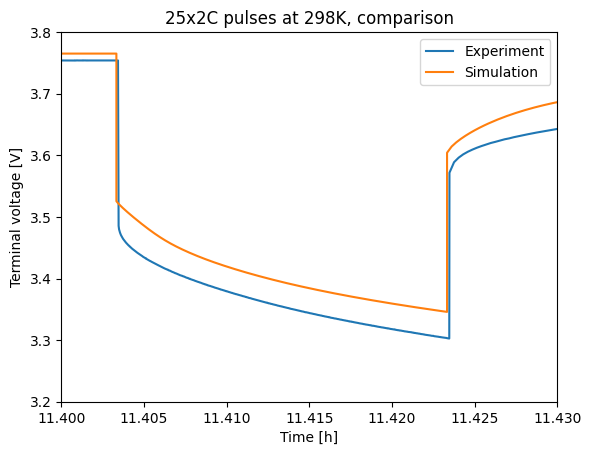

In [6]:
fig, ax = plt.subplots()
ax.plot(t_exp-t_exp[0],V_exp,label='Experiment')
ax.plot(t_hours,V,label='Simulation')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Terminal voltage [V]')
ax.set_title('25x2C pulses at 298K, comparison')
ax.legend()
plt.xlim(11.4,11.43)
plt.ylim(3.2,3.8)
#plt.savefig('/mnt/c/Users/sokane/pybamm_data/validation_data/GITT_2C_discharge_298K_zoomed.png')
plt.show()

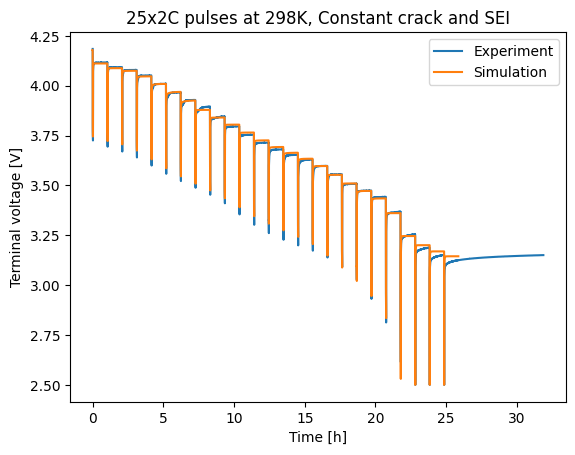

In [10]:
fig, ax = plt.subplots()
ax.plot(t_exp-t_exp[0],V_exp,label='Experiment')
ax.plot(t_hours,V,label='Simulation')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Terminal voltage [V]')
ax.set_title('25x2C pulses at 298K, Constant crack and SEI')
ax.legend()
#plt.xlim(-0.02,0.12)
#plt.ylim(4,4.2)
SavePath = os.path.expanduser("~/EnvPBGEM_Linux/SimSave/P2_R9_Dim/GITT_Validation/") #
plt.savefig(
    SavePath +  
    f"25x2C pulses at 298K, comparison - Simon.png", 
    dpi=300)